# Regrid NorESM data to DGGS

## Description

The BLOM ocean data lives on a tripolar grid.  
This grid is irregular: An (x,y) grid with individual latitude and longitude values for each grid point. We can use x and y as indices.  
plat (2-dimensional, matches (x,y) grid) stores the latitude values of the points.  
x and y are simply dimensionless coordinates in the array to coordinate latitude, longitude, and temperature, which is stored as a 2D array of the same shape as (x,y).  
The example data in this notebook contains temperature at a single time point.  
We use netcdf functionality to regrid it to PlateCarree and then to xdggs.  

### This notebook step by step:

1. Load required libraries
2. Load sea surface temperature data on tripolar grid
3. Load regridded dataset with PlateCarree grid
4. Define DGGS target grid and regrid from PlateCarree to DGGS
5. Save the regridded data to zarr

## Contributions
- Even Moa Myklebust, Simula Research Laboratory (Norway) (author), @evenmm
- Anne Fouilloux, Simula Research Laboratory (Norway) (reviewer), @annefou
- Ola Formo Kihle, Independent Consultant / UW Contractor (Norway) (reviewer), @ofk123
- Yanchun He, NERSC (Norway) (provider of data and tutorial functions for loading data), @YanchunHe

## Bibliography and other interesting resources
- [The Norwegian Earth System Model (NorESM)](https://noresm-docs.readthedocs.io/en/latest/)
- [An introduction to NorESM model output and post-processing](https://nordicesmhub.github.io/noresmdiagnostics/)

## 1. Load required libraries

In [1]:
# Install xarray-healpy and dggs libraries for regridding
%pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-0ht0s6ue
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-0ht0s6ue
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 8ebd09eb7db4ee4bc9b12f8dd05ccd436986a93c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/xarray-contrib/xdggs.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-wiyzfa0q
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/xdggs.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-wiyzfa0q
  Resolved https://github.com/xarray-contrib/xdggs.git to commit a22be6b48837b2a1b90067e9fce69b7f4725dd70
  Installing build de

In [2]:
from pathlib import Path
import numpy as np
import xarray as xr  # N-dimensional arrays with dimension, coordinate and attribute labels
import cartopy.crs as ccrs  # Map projections
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import s3fs

warnings.simplefilter("ignore", category=DeprecationWarning)
xr.set_options(display_expand_data=False, display_expand_attrs=False, keep_attrs=True)

In [3]:
# Local imports
from data_handling import load_grid_vertex, standardize_variable_names, regrid_to_dggs

## 2. Load sea surface temperature data on tripolar grid

In [4]:
# Define file paths
endpoint_url = 'https://server-data.fair2adapt.sigma2.no'
tripolar_grid_data_path = "s3://CS1/data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc"

# Extract files from S3
client_kwargs={'endpoint_url': endpoint_url}
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=client_kwargs)

# Get tripolar grid data (Opening the ds typically takes a few minutes)
ds = xr.open_dataset(s3.open(tripolar_grid_data_path))

# Display the subset dataset
ds

<xarray.Dataset> Size: 554kB
Dimensions:  (time: 1, y: 385, x: 360)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 554kB ...

In [5]:
# Get grid location information
grid_file_path = "s3://CS1/data/grid/grid.nc"
plat, plon, pclat, pclon = load_grid_vertex(s3.open(grid_file_path))

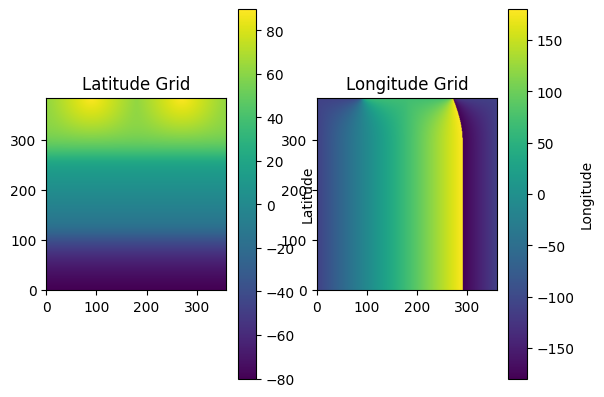

In [6]:
# Plot plat and plon to visualize the grid

plt.subplot(1, 2, 1)
plt.imshow(plat, origin="lower")
plt.colorbar(label="Latitude")
plt.title("Latitude Grid")

plt.subplot(1, 2, 2)
plt.imshow(plon, origin="lower")
plt.colorbar(label="Longitude")
plt.title("Longitude Grid")

plt.show()

In [7]:
print(np.max(plat), np.min(plat), np.max(plon), np.min(plon))

89.75749503829726 -80.11491140591812 179.9889159673213 -179.9967955192592


In [8]:
ds

<xarray.Dataset> Size: 554kB
Dimensions:  (time: 1, y: 385, x: 360)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 554kB ...

In [9]:
ds = ds.assign_coords(lat=(["y", "x"], plat), lon=(["y", "x"], plon))
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 1, y: 385, x: 360)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
    lat      (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    lon      (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 554kB ...

In [10]:
# latitude and longitude variables, not dimensions
ds = standardize_variable_names(ds)
ds

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 1, y: 385, x: 360)
Coordinates:
  * time       (time) object 8B 2010-01-17 00:00:00
    latitude   (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    longitude  (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x
Data variables:
    sst        (time, y, x) float32 554kB ...

In [11]:
# Center the data
ds.coords["longitude"] = (ds.coords["longitude"] + 180) % 360 - 180

In [12]:
print(
    "Percentage of nan values for sst: {0:.05f}".format(
        np.isnan(ds.sst.to_numpy()).sum() / ds.sst.size
    )
)

Percentage of nan values for sst: 0.37440


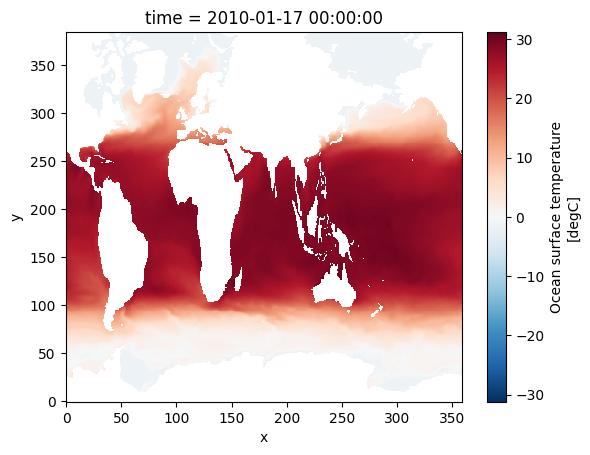

In [13]:
# Plot sea surface temperature on tripolar grid naively, using x and y
ds.sst.isel(time=0).plot()

When we plot using x and y, it looks like the North pole is missing, but this is just due to the tripolar projection.  
This is where the two northern poles are, hence the singularities where the North edges of Russia and Canada are "glued together".

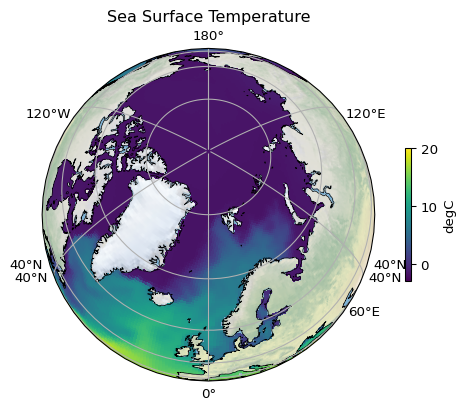

In [14]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    plon,
    plat,
    ds.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)


# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

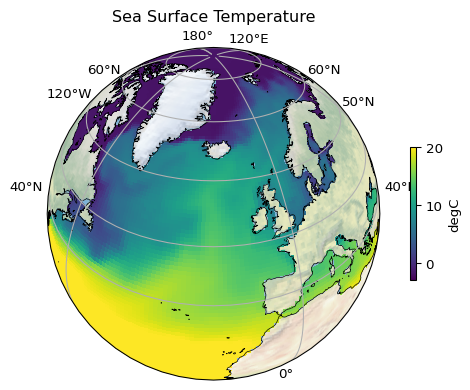

In [15]:
proj = ccrs.NearsidePerspective(
    central_longitude=-20.0, central_latitude=55.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    plon,
    plat,
    ds.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)


# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

In [16]:
del ds

# 3. Load regridded dataset with PlateCarree grid

This data can be regridded to PlateCarree using [cdo](https://code.mpimet.mpg.de/projects/cdo/wiki/tutorial): 

```console
brew install netcdf  
brew install nco  
```

Append (-A) the variables plat and plon from grid.nc into blom_sst.nc:  

```console
ncks -A -v plat,plon ./data/grid/grid.nc ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc  
```

Bilinear regridding:  
```console
cdo -O remapbil,global_1 ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc blom_sst_1x1d.nc  
```

Conservative regridding also needs corner coordinates, and we need to assign standard names to the corners. 
```console
ncks -A -v plon,plat,pclon,pclat ./data/grid/grid.nc ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc
ncdump -h ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc
ncrename -v pclat,lat_bnds -v pclon,lon_bnds ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc
cdo -O remapcon,global_1 ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc blom_sst_1x1d_conservative.nc  
```

# Load data regridded with bilinear interpolation

In [ ]:
# This data is not uploaded to S3 yet
# bilinear_regridded_data_path = "s3://CS1/data/model/JRAOC20TRNRPv2_hm_sst_2010-01_bil.nc"
# dr = xr.open_dataset(s3.open(bilinear_regridded_data_path))
# dr

In [ ]:
local_data_path = Path("./CS1-nird/data/")

# Path to data regridded from tripolar to platecarree using regrid_tripolar_to_platecarree.sh
bilinear_regridded_data_path = (
    local_data_path / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01_bil.nc"
)
dr = xr.open_dataset(bilinear_regridded_data_path)
dr

<xarray.Dataset> Size: 264kB
Dimensions:  (time: 1, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (time, lat, lon) float32 259kB ...
Attributes: (6)

In [18]:
dr = dr.rename_dims({"lat": "latitude", "lon": "longitude"})
#dr = dr.swap_dims({"lat": "latitude", "lon": "longitude"})
dr.latitude.attrs["standard_name"] = "latitude"
dr.longitude.attrs["standard_name"] = "longitude"
dr[["longitude", "latitude"]].compute()
dr = dr.rename({"lon": "longitude", "lat": "latitude"})
#dr = dr.rename_vars({"lon": "longitude", "lat": "latitude"})

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78206/684757710.py:6: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78206/684757710.py:6: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})


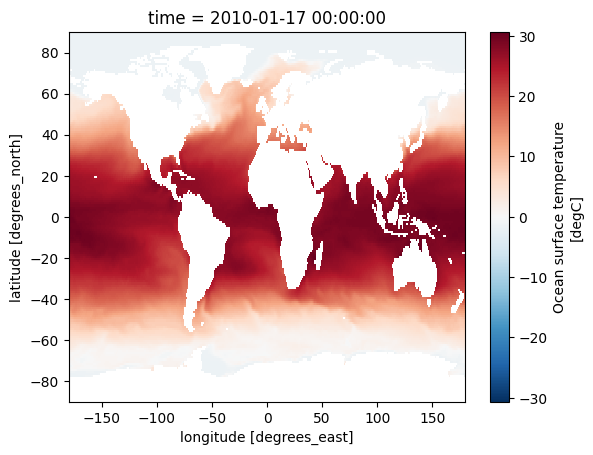

In [19]:
dr.sst.isel(time=0).plot()

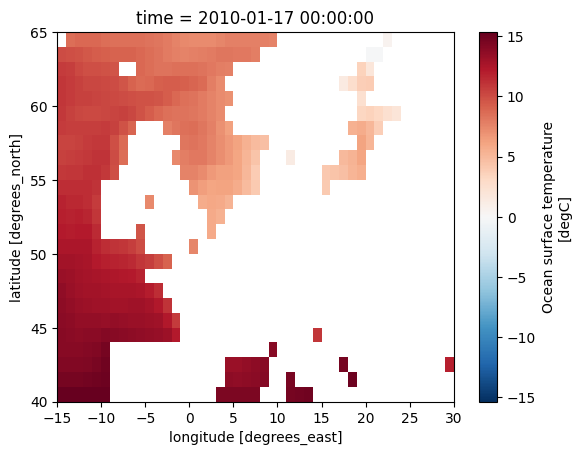

In [20]:
# Have a closer look at a region of interest
lat_min, lat_max = 40, 65
lon_min, lon_max = -15, 30
dr_zoomed = dr.sst.isel(time=0).sel(
    latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max)
)
# Plot only the region
dr_zoomed.plot()

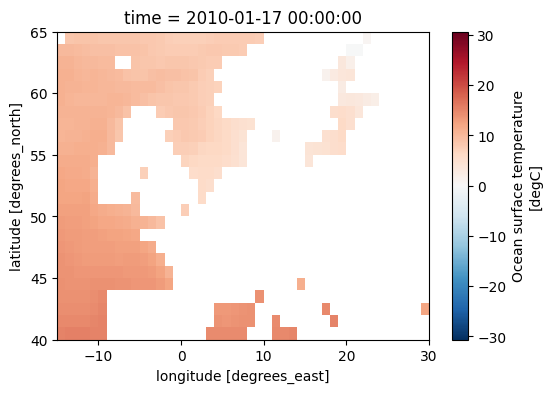

In [21]:
# Alternative way of plotting the region of interest
fig, ax = plt.subplots(figsize=(6, 4))
p = dr.sst.isel(time=0).plot(ax=ax)

# Set zoom limits
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

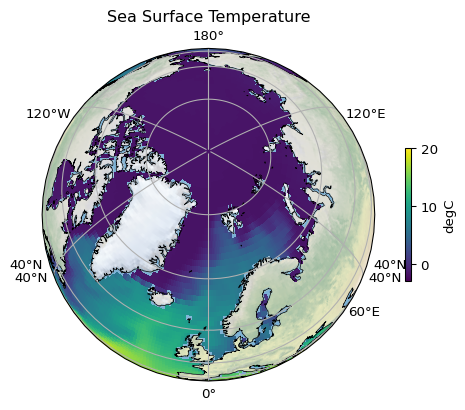

In [22]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    dr.longitude,
    dr.latitude,
    dr.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)

# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

In [23]:
print(
    "Percentage of nan values for sst: {0:.05f}".format(
        np.isnan(dr.sst.to_numpy()).sum() / dr.sst.size
    )
)

Percentage of nan values for sst: 0.36619


From the above cell we see that the percentage of nan cells has gone down when regridding to the PlateCarree grid.  
Naively, one would think that this indicates a liberal policy of how many vertices (min_vertices) are needed to assign value to a cell, and that for the purposes of this notebook, this is good because it keeps as much information as possible.  
On second thought though, this could possibly be due to the nature of where cells are located, meaning that we do not know how the effect on the total **area** covered by nan.

Define an ocean mask using the nan values of SST:

In [24]:
ocean_mask = ~dr.sst.isel(time=0).isnull()  # Mask land as False, ocean as True

# Load conservatively regridded

In [27]:
# This data is not uploaded to S3 yet
# conservative_regridded_dataset_path = "s3://CS1/data/model/JRAOC20TRNRPv2_hm_sst_2010-01_con.nc"
# dcon = xr.open_dataset(s3.open(conservative_regridded_dataset_path))
# dcon

# Path to data regridded from tripolar to platecarree using regrid_tripolar_to_platecarree.sh
conservative_regridded_dataset_path = (
    local_data_path / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01_con.nc"
)
dcon = xr.open_dataset(conservative_regridded_dataset_path)
dcon

<xarray.Dataset> Size: 264kB
Dimensions:  (time: 1, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (time, lat, lon) float32 259kB ...
Attributes: (6)

In [28]:
dcon = dcon.rename_dims({"lat": "latitude", "lon": "longitude"})
dcon.latitude.attrs["standard_name"] = "latitude"
dcon.longitude.attrs["standard_name"] = "longitude"
dcon[["longitude", "latitude"]].compute()
dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78206/3669483257.py:5: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78206/3669483257.py:5: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})


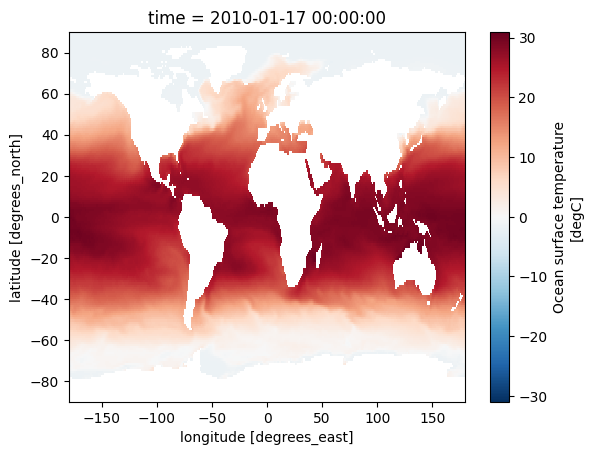

In [29]:
dcon.sst.isel(time=0).plot()

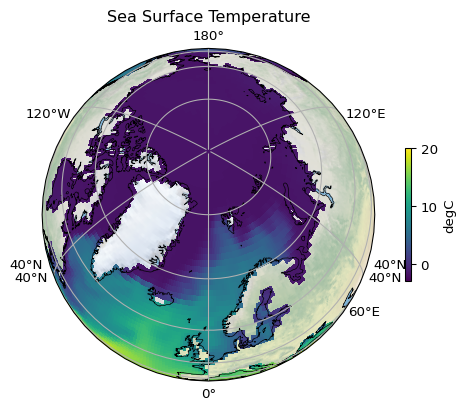

In [30]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    dcon.longitude,
    dcon.latitude,
    dcon.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)

# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

In [31]:
regrid_diff = dr - dcon
regrid_diff

<xarray.Dataset> Size: 264kB
Dimensions:    (time: 1, longitude: 360, latitude: 180)
Coordinates:
  * time       (time) object 8B 2010-01-17 00:00:00
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    sst        (time, latitude, longitude) float32 259kB nan nan ... -0.0004274
Attributes: (6)

In [32]:
print(
    np.max(regrid_diff), np.min(regrid_diff), np.max(regrid_diff), np.min(regrid_diff)
)

<xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    sst      float32 4B 0.6398
Attributes: (6) <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    sst      float32 4B -0.7489
Attributes: (6) <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    sst      float32 4B 0.6398
Attributes: (6) <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    sst      float32 4B -0.7489
Attributes: (6)


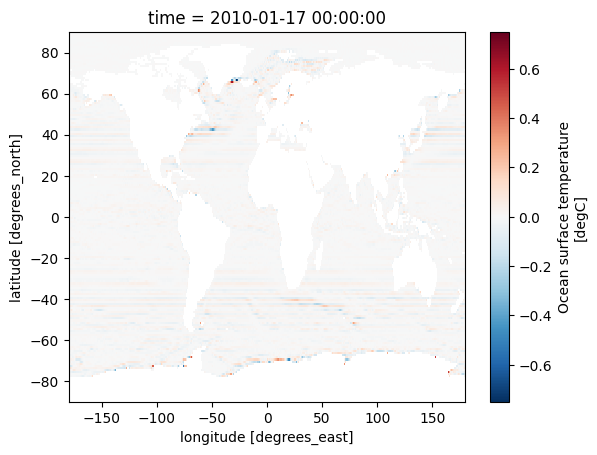

In [33]:
regrid_diff.sst.isel(time=0).plot()

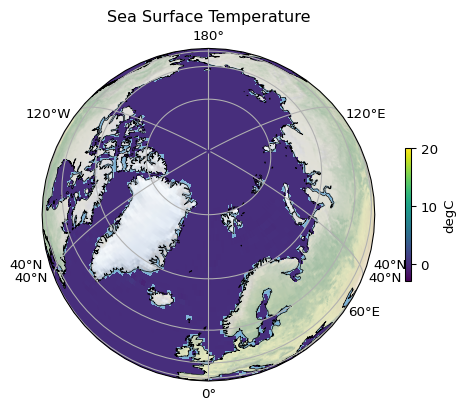

In [34]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    regrid_diff.longitude,
    regrid_diff.latitude,
    regrid_diff.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)

# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

# 4. Define target grid and regrid from PlateCarree to Healpy DGGS

In [35]:
nside = 256  # Each side of the original 12 faces in Healpix is divided into nside parts
healpy_grid_level = int(np.log2(nside))  # Healpix level
number_of_cells = 12 * nside**2  # The resulting total number of cells

min_vertices = 2  # Minimum number of vertices for a valid transcription for regridding.
# 1 is the most liberal, meaning that only one is needed

print("nside:", nside)
print("Level:", healpy_grid_level)
print("Number of cells:", number_of_cells)

nside: 256
Level: 8
Number of cells: 786432


In [36]:
# Perform the actual regridding
regridded = regrid_to_dggs(
    dcon, nside, min_vertices, method="bilinear", mask=ocean_mask
)

/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/xarray_healpy/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


In [37]:
ds_regridded = regridded.sst.compute().squeeze()

In [38]:
ds_regridded.dggs.explore()

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

# 5. Save the regridded data to zarr

In [39]:
save_location = Path("./data/") / f"SST-healpix-lvl-{healpy_grid_level}.zarr"
ds_regridded.to_zarr(save_location, mode="w")

/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
